In [1]:
import GCRCatalogs
from GCR import GCRQuery
import h5py
import pandas as pd
import numpy as np
#grab the dust model
from lsst.sims.catUtils.dust import EBVbase
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ebv_gen = EBVbase()

In [3]:
def compute_ebv(ra,dec):
    """
    compute ebv vector for a set of ra's and dec's, inputs assumed to be in degrees 
    though calculateEbv assumes radians, so need to convert
    inputs: ra, dec:
      vectors of sky coords in degrees
    returns:
    ebv:
      vector of E(B-V values from CCM model
    """
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    eq_coords = np.array([ra_rad,dec_rad])
    ebv_vec = ebv_gen.calculateEbv(equatorialCoordinates=(eq_coords),interp=True)
    return ebv_vec

In [4]:
def make_catalog(gc,tract):
    """
    function to make a pandas dataframe with some basic info for a tract/patch for all six bands 
    inputs:
    gc: catalog reader
    tract: int; tract number
    returns:
    Pandas dataframe with mags and dereddened mags, plus a few columns
    """
    
    bands = ['u','g','r','i','z','y']
    columns = ['ra','dec','extendedness','blendedness','tract','patch','objectId']
    for band in bands:
        columns.append('mag_{}_cModel'.format(band))
        columns.append('magerr_{}_cModel'.format(band))
        columns.append('snr_{}_cModel'.format(band))
        columns.append('cModelFlux_{}'.format(band))
        columns.append('cModelFluxErr_{}'.format(band))
    
    data = gc.get_quantities(columns,native_filters=[f'tract=={tract}'])
    #for i,data in enumerate(gc.get_quantities(columns,return_iterator=True)):
    df = pd.DataFrame(data)
    ebv_vec = compute_ebv(df['ra'],df['dec'])
    df['ebv']=ebv_vec
    tract = df['tract'][0]
    patch = df['patch'][0]
    patch0,patch1 = patch.split(',')

    band_meanlam = [3671., 4827.,6223.,7546.,8691.,9710.] #mean wl for ugrizy filters
    #A/E(B-V) calculated from CCM model that Scott said was used for run2.1i
    band_a_ebv = np.array([4.81,3.64,2.70,2.06,1.58,1.31]) 

    for ii,band in enumerate(bands):
        #add dereddened magnitudes and re-calculate log version of errors    
        deredden_mag = ebv_vec*band_a_ebv[ii]
        cmod_dered =df[f"mag_{band}_cModel"] - deredden_mag
        df[f"cModel_{band}_dered"]=cmod_dered
        invsn = 1./df[f"snr_{band}_cModel"]
        logmagerr = 2.5*np.log10(1.+invsn)
        df[f"magerrlog_{band}_dered"] = logmagerr

    return df


In [5]:
catalog_name='dc2_object_run2.1i_dr1b'
tract = 4850
gc = GCRCatalogs.load_catalog(catalog_name)
df = make_catalog(gc,tract)

In [6]:
#print('\n'.join(sorted(GCRCatalogs.get_available_catalogs(False))))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514882 entries, 0 to 514881
Data columns (total 50 columns):
cModelFluxErr_u      480810 non-null float64
dec                  514882 non-null float64
snr_z_cModel         488787 non-null float64
snr_r_cModel         507281 non-null float64
cModelFluxErr_g      472518 non-null float64
cModelFlux_y         502759 non-null float64
ra                   514882 non-null float64
cModelFluxErr_z      488787 non-null float64
magerr_i_cModel      506206 non-null float64
tract                514882 non-null int64
magerr_y_cModel      494104 non-null float64
snr_i_cModel         506206 non-null float64
mag_z_cModel         438422 non-null float64
mag_i_cModel         493527 non-null float64
magerr_z_cModel      488787 non-null float64
magerr_u_cModel      480810 non-null float64
snr_y_cModel         494104 non-null float64
cModelFluxErr_y      494104 non-null float64
magerr_g_cModel      472518 non-null float64
mag_u_cModel         400216 non-null

In [7]:
minra = np.amin(df['ra'])
maxra = np.amax(df['ra'])
mindec = np.amin(df['dec'])
maxdec = np.amax(df['dec'])

In [8]:
truthcat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [9]:
radec_mask = [f'ra>={minra}',f'ra<{maxra}',f'dec>={mindec}',f'dec<{maxdec}',(np.isfinite,'mag_i_lsst'),'mag_i_lsst<25.0']

In [10]:
truth_data = truthcat.get_quantities(['ra','dec','redshift','mag_u_lsst','mag_g_lsst','mag_r_lsst',
                                      'mag_i_lsst','mag_z_lsst','mag_y_lsst','galaxy_id'],filters=radec_mask)

In [11]:
print(len(truth_data['ra']))

322931


In [12]:
import FoFCatalogMatching

In [13]:
results = FoFCatalogMatching.match(catalog_dict={'truth':truth_data,'obs':df},linking_lengths=1.0,
                                   catalog_len_getter= lambda x: len(x['ra']))

In [14]:
#grab just the 1:1 matches

In [15]:
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

In [16]:
truthdf = pd.DataFrame(truth_data).iloc[truth_idx].reset_index(drop=True)

In [17]:
objdf = pd.DataFrame(df).iloc[object_idx].reset_index(drop=True)

In [18]:
bigdf = pd.merge(truthdf,objdf,left_index=True,right_index=True,suffixes = ('_truth','_obj'))

In [19]:
bigdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277295 entries, 0 to 277294
Data columns (total 60 columns):
galaxy_id            277295 non-null int64
dec_truth            277295 non-null float64
mag_z_lsst           277295 non-null float64
ra_truth             277295 non-null float64
mag_u_lsst           277295 non-null float64
mag_y_lsst           277295 non-null float64
mag_i_lsst           277295 non-null float64
mag_g_lsst           277295 non-null float64
redshift             277295 non-null float64
mag_r_lsst           277295 non-null float64
cModelFluxErr_u      258573 non-null float64
dec_obj              277295 non-null float64
snr_z_cModel         267833 non-null float64
snr_r_cModel         276734 non-null float64
cModelFluxErr_g      255832 non-null float64
cModelFlux_y         273723 non-null float64
ra_obj               277295 non-null float64
cModelFluxErr_z      267833 non-null float64
magerr_i_cModel      276612 non-null float64
tract                277295 non-null

In [20]:
brightmask = ((bigdf['mag_i_cModel']<22.) & (bigdf['blendedness']<.1) & (bigdf['ebv']>.013))
brightdf = bigdf[brightmask]

In [21]:
delu = brightdf['mag_u_cModel']-brightdf['mag_u_lsst']
delu_dered = brightdf['cModel_u_dered']-brightdf['mag_u_lsst']
print(np.nanmedian(delu))
print(np.nanmedian(delu_dered))

-0.061109986978227226
-0.12780656024699333


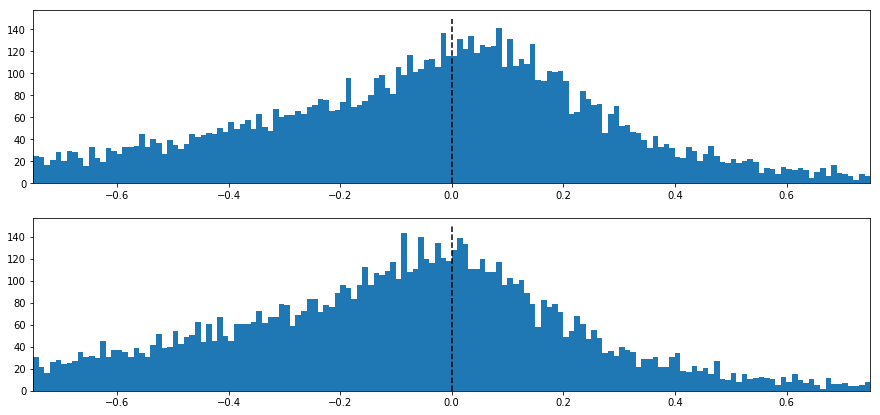

In [22]:
bins =np.arange(-2.5,2.5,0.01)
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(211)
plt.hist(delu,bins=bins)
plt.xlim(-.75,.75)
plt.plot([0,0],[0,150],'k--')
bx = plt.subplot(212)
plt.hist(delu_dered,bins=bins)
plt.xlim(-.75,.75)
plt.plot([0,0],[0,150],'k--')

In [23]:
delg = bigdf['mag_g_cModel']-bigdf['mag_g_lsst']
delg_dered = bigdf['cModel_g_dered']-bigdf['mag_g_lsst']
print(np.nanmedian(delg))
print(np.nanmedian(delg_dered))

-0.0066903548750953945
-0.05319134186677488


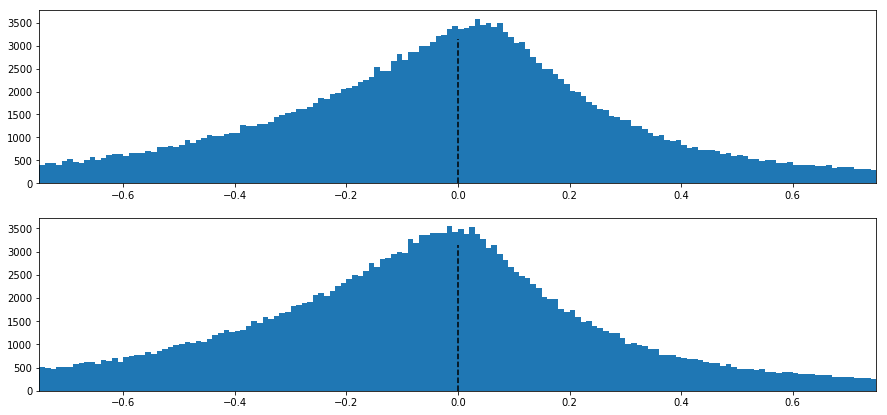

In [24]:
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(211)
plt.hist(delg,bins=bins)
plt.xlim(-.75,.75)
plt.plot([0,0],[0,3150],'k--')
bx = plt.subplot(212)
plt.hist(delg_dered,bins=bins)
plt.xlim(-.75,.75)
plt.plot([0,0],[0,3150],'k--')

In [25]:
delr = bigdf['mag_r_cModel']-bigdf['mag_r_lsst']
delr_dered = bigdf['cModel_r_dered']-bigdf['mag_r_lsst']
print(np.nanmedian(delr))
print(np.nanmedian(delr_dered))

0.0027335728922075475
-0.03191049074597174


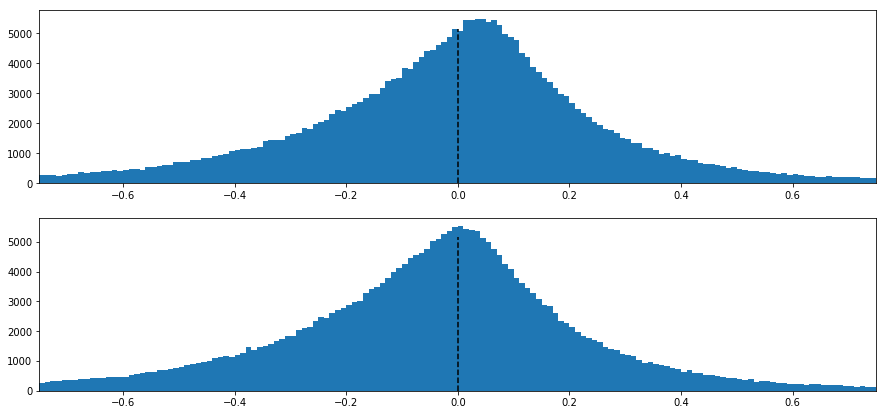

In [26]:
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(211)
plt.hist(delr,bins=bins)
plt.xlim(-.75,.75)
plt.plot([0,0],[0,5150],'k--')
bx = plt.subplot(212)
plt.hist(delr_dered,bins=bins)
plt.xlim(-.75,.75)
plt.plot([0,0],[0,5150],'k--')

In [27]:
deli = bigdf['mag_i_cModel']-bigdf['mag_i_lsst']
deli_dered = bigdf['cModel_i_dered']-bigdf['mag_i_lsst']
print(np.nanmedian(delr))
print(np.nanmedian(delr_dered))

0.0027335728922075475
-0.03191049074597174


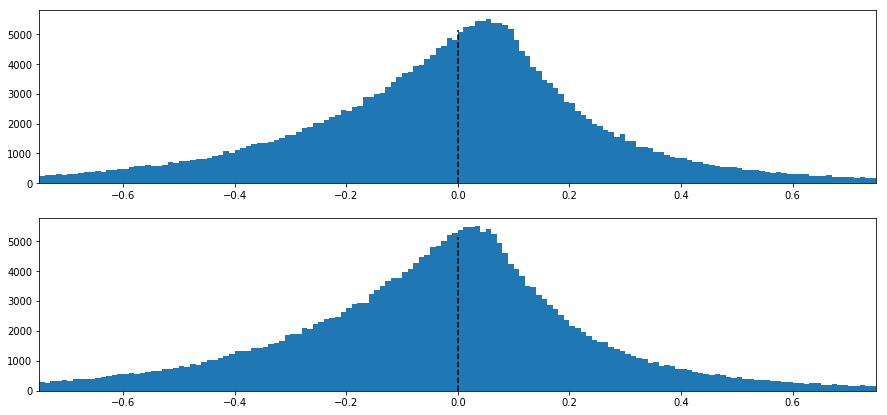

In [28]:
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(211)
plt.hist(deli,bins=bins)
plt.xlim(-.75,.75)
plt.plot([0,0],[0,5150],'k--')
bx = plt.subplot(212)
plt.hist(deli_dered,bins=bins)
plt.xlim(-.75,.75)
plt.plot([0,0],[0,5150],'k--')

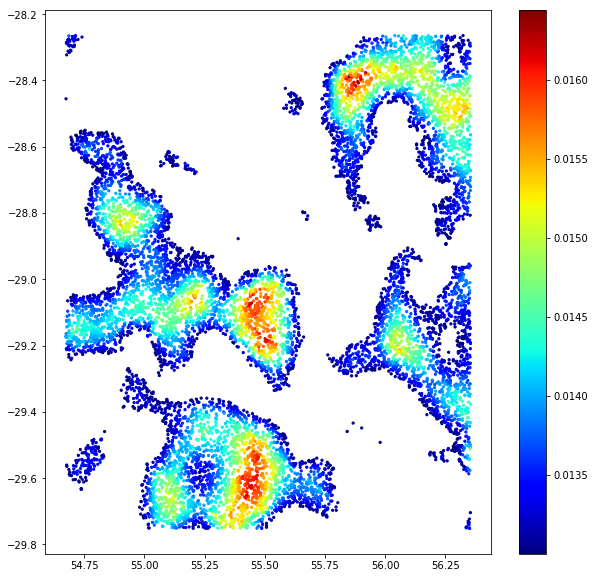

In [29]:
fig = plt.figure(figsize=(10,10))
plt.scatter(brightdf['ra_obj'],brightdf['dec_obj'],s=5,c=brightdf['ebv'],cmap='jet')
plt.colorbar()
#plt.clim(0.)